# Run LIANA & MOFA

## Setup Env

In [1]:
import os, fnmatch

import numpy as np
import pandas as pd

import scanpy as sc
import squidpy as sq

In [2]:
import liana as li
from liana.method.sp import lr_basis, basis

In [3]:
from mudata import MuData
import muon as mu
import mofax as mofa

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
data_dir = "/home/dbdimitrov/Repos/liana2_manuscript/data/kidney_injury/"

## Load Processed Objects

### Load Visium

In [5]:
# slides = fnmatch.filter(os.listdir(os.path.join(data_dir, 'visium', 'deconv')), '*.h5ad')
slides = fnmatch.filter(os.listdir(os.path.join(data_dir, 'visium')), '*.h5ad')

In [6]:
adatas = dict()
for slide in slides:
    # adatas[slide] = sc.read_h5ad(os.path.join(data_dir, 'visium', 'deconv', slide))
    adatas[slide] = sc.read_h5ad(os.path.join(data_dir, "visium", slide))
    sample = slide[:-5].split('_')[0]
    print(sample)
    adatas[slide].obs['sample'] = sample
    

f6wks
f12hr
f4hr
fsham
f2dps


## Run LIANA

In [7]:
lrdatas = []
for sample in adatas.keys():
    adata = adatas[sample].copy()
    
    
    sq.gr.spatial_neighbors(adata, n_rings=1, coord_type="grid", n_neighs=6)
    # TODO convert this to np.float32 internally
    
    lr_basis(adata,
            function_name="jaccard",
            expr_prop=0.1,
            resource_name="MouseConsensus", 
            pvalue_method=None, 
            use_raw=False, 
            #  positive_only=True,
            proximity_key="spatial_connectivities",
            )
    # extract the local scores
    temp = li.fun.obsm_to_adata(adata, 'local_scores')
    lrdatas.append(temp)


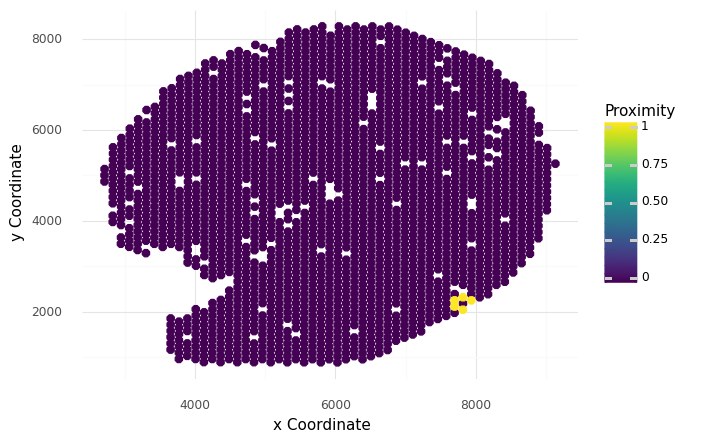

<ggplot: (8780636761926)>

In [8]:
li.pl.proximity_plot(adata, idx=1, spatial_key='spatial', proximity_key='spatial_connectivities')

In [139]:
lrdatas[0]

AnnData object with n_obs × n_vars = 1514 × 841
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'leiden'
    uns: 'log1p', 'spatial', 'spatial_neighbors', 'global_res'
    obsm: 'spatial', 'local_scores'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [9]:
lrdata = lrdatas[0]

In [10]:
adata.uns['global_res'].sort_values('global_mean').tail(10)

,ligand,receptor,ligand_means,ligand_props,receptor_means,receptor_props,interaction,global_mean,global_sd
174,Tgm2,Itgb1,1.062551,0.847393,1.238781,0.862085,Tgm2&Itgb1,0.780537,0.245009
1113,Spp1,Itgav_Itgb1,5.205983,1.000000,0.987975,0.802844,Spp1&Itgav_Itgb1,0.805632,0.243830
2334,Timp1,Cd63,1.136890,0.811848,2.720397,0.994787,Timp1&Cd63,0.813973,0.246151
197,Tgm2,Sdc4,1.062551,0.847393,1.554439,0.931280,Tgm2&Sdc4,0.819289,0.205409
507,App,Aplp2,1.451256,0.928436,1.149898,0.877725,App&Aplp2,0.856303,0.182598
1157,Mfge8,Itgav,1.465557,0.923697,1.351061,0.903791,Mfge8&Itgav,0.861919,0.202380
506,H2-K1,Aplp2,1.565722,0.951659,1.149898,0.877725,H2-K1&Aplp2,0.864321,0.177198
154,Lgals1,Itgb1,2.485018,0.984360,1.238781,0.862085,Lgals1&Itgb1,0.864415,0.194182
1154,Calr,Itgav,2.238762,0.986256,1.351061,0.903791,Calr&Itgav,0.902828,0.170304
530,App,Rpsa,1.451256,0.928436,3.547689,0.999526,App&Rpsa,0.929566,0.127791


In [141]:
# save results as modalities
local_lr  = li.fun.obsm_to_adata(adata, 'local_scores')
# local_pvals = li.fun.obsm_to_adata(adata, 'local_pvals')

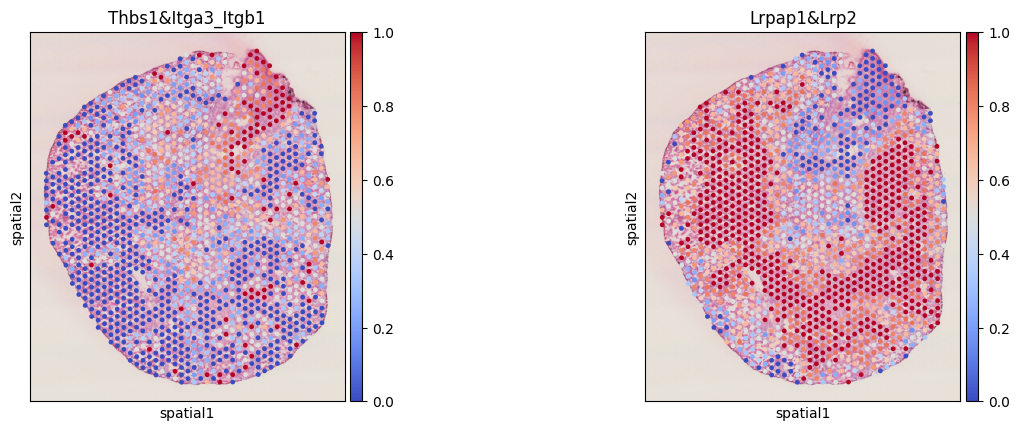

In [143]:
sc.pl.spatial(local_lr, color=['Thbs1&Itga3_Itgb1', 'Lrpap1&Lrp2'], cmap='coolwarm')

## Run MOFAcell

In [16]:
adata = sc.concat(adatas=adatas)
adata.obs['leiden'] = adata.obs['leiden'].replace({'5':'2'})

In [17]:
mdata = li.multi.adata_to_views(adata,
                                groupby='leiden',
                                sample_key='sample',
                                obs_keys=None,
                                min_prop=0.05, # min nnz values (filter features)
                                min_smpls=3, # min samples per view (filter features)
                                min_cells=25, # min cells per view (filter samples)
                                min_counts=100, # min counts per view (filter samples)
                                mode='sum', # mode of aggregation
                                verbose=True,
                                skip_checks=True,
                                layer='counts'
                                )

100%|██████████| 5/5 [00:00<00:00,  5.99it/s]


In [18]:
for mod in mdata.mod.keys():
    sc.pp.normalize_total(mdata.mod[mod], target_sum=1e4)
    sc.pp.log1p(mdata.mod[mod])
    
    sc.pp.highly_variable_genes(mdata.mod[mod], min_mean=0.0125, max_mean=3, min_disp=0.5)

In [19]:
model = mu.tl.mofa(mdata, 
                   use_obs='union',
                   convergence_mode='medium',
                   outfile="models/mofacell.hdf5",
                   n_factors=4,
                   use_var='highly_variable'
                   )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='4' group='group1' with N=5 samples and D=7741 features...
Loaded view='1' group='group1' with N=5 samples and D=9674 features...
Loaded view='3' group='group1' with N=5 samples and D=10690 features...
Loaded view='2' group='group1' with N=5 samples and D=10097 features...
Loaded view='0' group='group1' with N=5 samples and D=8821 features...


Model options:
- Autom

In [20]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()

,index,Factor_1,Factor_2,Factor_3,Factor_4
0,f12hr,-0.004926,-1.152847e-269,9.487770e-271,1.892844e-202
1,f2dps,-0.018181,-2.866026e-270,2.355650e-271,5.336465e-203
2,f4hr,0.056119,1.222663e-270,-1.002215e-271,-2.592442e-203
3,f6wks,-0.029441,5.213405e-270,-4.284223e-271,-9.471459e-203
4,fsham,-0.009083,7.898771e-270,-6.507769e-271,-1.211318e-202


In [21]:
model = mofa.mofa_model("models/mofacell.hdf5")
model

MOFA+ model: mofacell
Samples (cells): 5
Features: 47023
Groups: group1 (5)
Views: 0 (8821), 1 (9674), 2 (10097), 3 (10690), 4 (7741)
Factors: 4
Expectations: W, Z

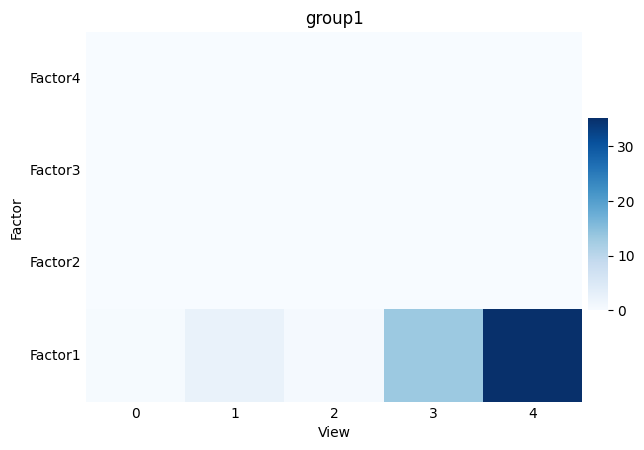

In [22]:
mofa.plot_r2(model, x='View')

In [58]:
model.close()

## Run MOFAtalk

In [23]:
lrdata = sc.concat(lrdatas, join='inner', fill_value=0)

In [24]:
lrdata.obs['group'] = lrdata.obs['sample'].str.split('_').str[0]

In [25]:
mdata = li.multi.adata_to_views(lrdata,
                                groupby='leiden',
                                sample_key='sample',
                                obs_keys=['group'],
                                min_prop=0.05, # min nnz values (filter features)
                                min_smpls=3, # min samples per view (filter features)
                                min_cells=25, # min cells per view (filter samples)
                                min_counts=0, # min counts per view (filter samples)
                                mode='mean', # mode of aggregation
                                verbose=True,
                                skip_checks=True
                                )

100%|██████████| 6/6 [00:00<00:00, 27.98it/s]


In [26]:
mdata

MuData object with n_obs × n_vars = 5 × 1090
  obs:	'group'
  6 modalities
    4:	4 x 170
      layers:	'psbulk_props'
    1:	5 x 184
      layers:	'psbulk_props'
    3:	5 x 184
      layers:	'psbulk_props'
    2:	5 x 184
      layers:	'psbulk_props'
    0:	5 x 184
      layers:	'psbulk_props'
    5:	2 x 184
      layers:	'psbulk_props'

In [30]:
model = mu.tl.mofa(mdata, 
                   use_obs='union',
                   convergence_mode='medium',
                   outfile="models/lrs.h5ad",
                   n_factors=5
                   )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='4' group='group1' with N=5 samples and D=170 features...
Loaded view='1' group='group1' with N=5 samples and D=184 features...
Loaded view='3' group='group1' with N=5 samples and D=184 features...
Loaded view='2' group='group1' with N=5 samples and D=184 features...
Loaded view='0' group='group1' with N=5 samples and D=184 features...
Loaded view='5' group='group1' 

In [31]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()


,sample,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,group
0,f12hr,0.004835,-1.182321e-137,4.128984e-155,-4.592029e-154,-3.128944e-151,f12hr
1,f2dps,-0.078487,-2.152855e-137,-2.647366e-155,2.400815e-154,1.442725e-151,f2dps
2,f4hr,0.142769,7.914764e-138,1.916960e-155,-1.879740e-154,-1.192909e-151,f4hr
3,f6wks,-0.079105,4.421981e-137,1.040342e-154,-1.004400e-153,-6.291508e-151,f6wks
4,fsham,0.011299,-1.952544e-137,-1.390797e-154,1.421465e-153,9.232729e-151,fsham


In [35]:
model = mofa.mofa_model("models/lrs.h5ad")
model


MOFA+ model: lrs.h5ad
Samples (cells): 5
Features: 1090
Groups: group1 (5)
Views: 0 (184), 1 (184), 2 (184), 3 (184), 4 (170), 5 (184)
Factors: 5
Expectations: W, Z

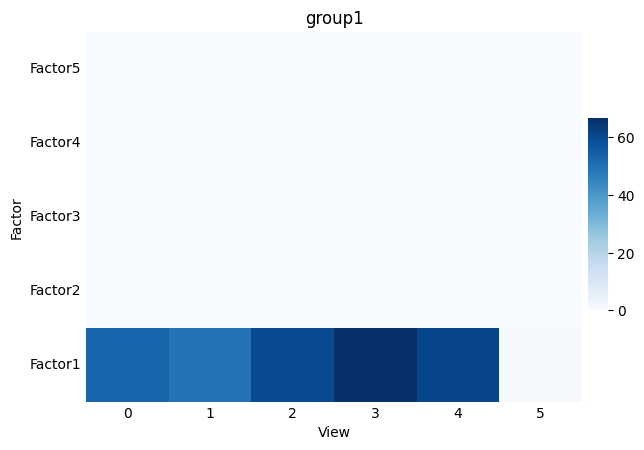

In [36]:
mofa.plot_r2(model, x='View')

In [39]:
factor1_loadings =  li.multi.get_variable_loadings(mdata, 0, view_separator=':') # get loadings for factor 1
## NOTE this should work, not only with 0...

In [41]:
factor1_loadings.head(10)

,loadings,view,variable
406,-3.171236,3,Col4a2&Itgb5
480,-3.149627,3,Lgals3bp&Itgb1
457,-3.105558,3,Lamb1&Dag1
478,-3.030846,3,Lgals1&Itgb1
362,-3.017516,3,Agrn&Dag1
528,-3.014549,3,Timp2&Itgb1
420,-2.986592,3,Cx3cl1&Itgav
426,-2.909273,3,Gas6&Axl
509,-2.854902,3,Sparc&Eng
479,-2.831939,3,Lgals3&Eng


## Run NMF

In [42]:
from sklearn.decomposition import NMF

In [43]:
adata = adatas['fsham_137_processed.h5ad'].copy()

In [44]:
del adata.uns['log1p']

In [45]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [46]:
adata = adata[:,adata.var['highly_variable']]

In [103]:
adata = lrdatas[0].copy()

In [104]:
# Load data into a matrix
X = np.random.rand(100, 50)

# Create an instance of the NMF class
model = NMF(n_components=10, init='random')

# Fit the model to the data and obtain the factorized matrices
W = model.fit_transform(adata.X)
H = model.components_

In [108]:
adata.obsm['NMF_W'] = pd.DataFrame(W, index=adata.obs.index)

In [109]:
ad_nmf = li.fun.obsm_to_adata(adata, 'NMF_W') ## NOTE take index from adata.obs.index, not from the obsm matrix

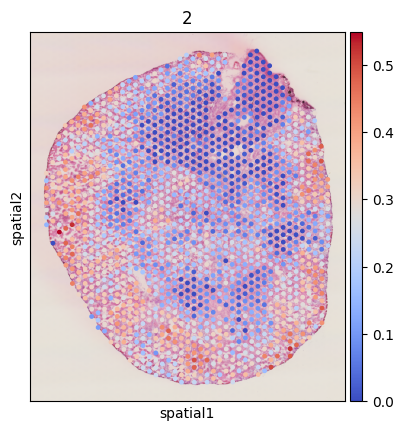

In [132]:
sc.pl.spatial(ad_nmf, color='2', cmap='coolwarm')

In [133]:
lr_loadings = pd.DataFrame(adata.varm['NMF_H'], index=adata.var.index)

In [135]:
lr_loadings.sort_values(2, ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9
App&Rpsa,0.487972,0.000000,1.778197,0.045559,0.209655,0.450129,0.560747,0.679175,0.747165,0.051805
App&Cd74,0.518580,0.000000,1.743597,0.093395,0.186834,0.464316,0.681235,0.290755,0.718807,0.061110
Apoe&Lrp2,0.000000,0.054243,1.647106,0.000000,0.000000,0.762679,0.283992,0.000000,1.034191,0.042536
Hspa8&Lrp2,0.000000,0.051790,1.644430,0.000000,0.000000,0.764600,0.282780,0.000000,1.034710,0.056875
Tcn2&Lrp2,0.000000,0.047135,1.623073,0.000000,0.000000,0.761860,0.271867,0.000000,1.040655,0.048473
H2-K1&Aplp2,0.508353,0.000000,1.542454,0.095847,0.148885,0.326875,0.581992,0.662820,0.730260,0.119898
App&Aplp2,0.512079,0.013177,1.482076,0.129247,0.200033,0.385830,0.562847,0.664225,0.735469,0.035409
Calr&Itgav,0.417869,0.032751,1.414981,0.002613,0.253915,0.640175,0.494338,0.340180,0.758193,0.012138
Lrpap1&Lrp2,0.000000,0.044591,1.362212,0.000000,0.000000,0.628807,0.299643,0.001408,1.074475,0.072233
Sparc&Eng,0.411716,0.078012,1.252510,0.133239,0.230216,0.570157,0.556919,0.494518,0.354520,0.019340
